<a href="https://colab.research.google.com/github/MatteoRigoni/MachineLearningPlayground/blob/master/Progetto_MachineLearningAvanzato_MatteoRigoni_v2_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sistema di Face Detection per fotocamera digitale

La *ProCam s.p.a*  ha intenzione di lanciare sul mercato una nuova fotocamera digitale compatta ed economica destinata a piccoli fotografi in erba.

Vieni assunto come Data Scientist per realizzare il sistema di identificazione dei volti nelle immagini, questo permetterà poi ai tecnici della fotografia di ottimizzare le impostazioni per un selfie con una o più persone.

Si tratta di un problema di computer vision, più precisamente di Face Detection.

Devi fornire una pipeline scikit-learn che prende un'immagine in ingresso e ritorna una lista con le coordinate dei bounding box dove sono presenti dei volti, se nell'immagine non contiene volti la lista sarà ovviamente vuota.

> Note addizionali
* Necessità di ricercare di un dataset di immagini
* Richiesta la generazione di un modello custom
* Poche risorse di calcolo a disposizione
* Citazione fonti



---

##Premessa
Si è eseguito lo studio su un primo dataset che si è rilevato essere troppo complesso come tipologia di immagini e non si sono ottenuti risultati accettabili, per cui si è poi provato a ripetere l'intero processo su un altro dataset più semplice.

Per evitare ripetizioni, non saranno riportate tutte le funzioni già definite e documentate nella prima parte.



---

#✍ Revisione progetto(17/07/2024) ✍

*   Si è commentata la parte di esecuzione del primo dataset per fare pulizia
*   Si è riscritta la funzione 'is_rect_intersected' in modo da avere in maniera nitida window contenenti volti e window contenenti qualsiasi cosa ma non il volto (in modo da simulare il fatto di avere due dataset diversi), I casi dubbi sono escludi dal training.
*   Si è usato GridSearchCV per trovare i migliori parametri di SVC lineare
*   Si è migliorata l'accuracy e lo score portandoli al 90% circa
*   Miglioramento output del box sull'immagine




___

#1. Progetto su dataset WIDERFACE

##1.1. Preparazione del dataset

Si utilizza il dataset [WIDERFACE](http://shuoyang1213.me/WIDERFACE/) che contiene 32.203 immagini con 393.703 bounding box di facce rilevate. I volti presentano angolazioni o sfondi molto vari, per consentire un addestramento più approfondito anche in situazioni che esulano da un classico *portrait* frontale.

Il dataset è già fornito suddiviso per le parti di training, validation e test. In questa prima fase utilizziamo quindi l'insieme di immagini di training.

Oltre al dataset con le immagini, si scarica anche il dataset di annotations, che contiene i riferimenti dei bonding box per le varie immagini.

Il file di indice per la sezione di train è *wider_face_train_bbx_gt.txt* dove per ogni immagine si ha:

* Percorso relativo dell'immagine (es. 0--Parade/0_Parade_marchingband_1_849.jpg)
* Indicazione del numero di volti (es. 1)
* n righe di vettori, uno per ogni volto coi seguenti campi espressi in *px*:

    0. top-left X
    1. top-left Y
    2. width
    3. height
    4. altre informazioni come l'angolo del viso, che non ci interessano e verranno poi escluse

In [ ]:
import os
import urllib.request
import zipfile

RANDOM_SEED=10

In [ ]:
def download_and_extract_remote_zip(remote_zip_url, temp_zip_path, zip_content_path, percent_number_file = 1):
  """
    Scarica uno zip e ne estrae il contenuto se non è già presente.

    Args:
        (str) remote_url: link a un file zip remoto
        (str) temp_zip_path: percorso temporaneo di copia dello zip
        (str) zip_content_path: cartella di estrazione del contenuto dello zip
        (int) percent_number_file: percentuale di file dello zip da considerare

    Returns:
        -
    """

  if not os.path.exists(zip_content_path):
    if not os.path.exists(temp_zip_path):
      urllib.request.urlretrieve(remote_zip_url, temp_zip_path)
    # with zipfile.ZipFile(temp_zip_path, 'r') as zip_file:
    #   zip_file.extractall(zip_content_path)

    # Estrai solo i primi 1000 file dal file ZIP
    with zipfile.ZipFile(temp_zip_path, 'r') as zip_file:
      file_list = zip_file.namelist()
      total_files = len(file_list)
      num_files_to_extract = int(total_files * percent_number_file / 100)

      for idx, file_name in enumerate(file_list):
        if idx < num_files_to_extract:
          zip_file.extract(file_name, zip_content_path)
        else:
          break
    os.remove(temp_zip_path)

In [ ]:
def count_images_in_folder(folder_path):
  """
    Conteggia il numero di file immagine in tutte le sottocartelle.

    Args:
        (str) folder_path: cartella root di ricerca

    Returns:
        (int) jpeg_files_count: numero di file jpeg
    """

  jpeg_files_count = sum(len([file for file in files if file.lower().endswith(('.jpeg', '.jpg'))]) for _, _, files in os.walk(folder_path))
  return jpeg_files_count



---



In [ ]:
# data_train_images_zip_url = 'https://huggingface.co/datasets/CUHK-CSE/wider_face/resolve/main/data/WIDER_train.zip?download=true'
# data_val_images_zip_url = 'https://huggingface.co/datasets/CUHK-CSE/wider_face/resolve/main/data/WIDER_val.zip?download=true'
# data_test_images_zip_url = 'https://huggingface.co/datasets/CUHK-CSE/wider_face/resolve/main/data/WIDER_test.zip?download=true'
# data_train_annotations_zip_url = 'http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip'

# download_and_extract_remote_zip(data_train_images_zip_url, 'WIDER_train_images.zip', 'WIDER_train_images')
# download_and_extract_remote_zip(data_val_images_zip_url, 'WIDER_train_images.zip', 'WIDER_val_images')
# download_and_extract_remote_zip(data_test_images_zip_url, 'WIDER_train_images.zip', 'WIDER_test_images')
# download_and_extract_remote_zip(data_train_annotations_zip_url, 'WIDER_train_annotations.zip', 'WIDER_train_annotations', 100)

# print(f"Numer of images on train dataset: {count_images_in_folder('WIDER_train_images')}")
# print(f"Numer of images on validation dataset: {count_images_in_folder('WIDER_val_images')}")
# print(f"Numer of images on test dataset: {count_images_in_folder('WIDER_test_images')}")

##1.2. Esplorazione del dataset

In questa fase si verificano i dati che abbiamo nel dataset per capire come sono distribuiti, utile in quanto essendo un dataset di terze parti non sappiamo se presenta anomalie particolari legate alla fase di etichettatura.

Si procede poi a rappresentare graficamente qualche bounding box sulla relativa immagine, al fine di avere un'idea chiara di come sono attribuite le label.

Dal risultato si evince come i box siano stati letti correttamente e come abbiano una dimensione molto varia, in quanto sono evidenziati sia volti in primo piano, grandi, che volti molto piccoli ad esempio nel pubblico. Si evince anche che la maggior parte dei volti sono centrati orizzontalmente e nella parte superiore delle immagini.

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns

random.seed(RANDOM_SEED)

In [ ]:
def load_face_annotations(rootPath, file_path, is_test_file:False):
  """
  Carica il file delle annotazioni del dataset con i bounding box.

  Args:
      (str) rootPath: percorso root delle immagini
      (str) file_path: File con le annotazioni sul percorso delle immagini, numero volti e bounding boxes.
      (bool) is_test_file: Nel file di test ci sono solo i box relativi alle immagini.

    Returns:
      (list) Lista di tuple, dove ogni tupla ha il percorso relativo dell'immagine e una lista di bounding box associati all'immagine.
            Ogni bounding box è una tupla di quattro valori (top-left X, top-left Y, width, height).
  """

  annotations = []
  with open(file_path, 'r') as file:
    lines = file.readlines()

  i = 0
  while i < len(lines):
    image_file = lines[i].strip()  #Path of image

    if not os.path.exists(f'{rootPath}/{image_file}'):
      i += 1
      continue

    if (is_test_file):
      annotations.append((image_file, []))
      i += 1
      continue

    num_faces = int(lines[i+1].strip())  #Number of faces

    if (num_faces == 0):
      i += 3
      continue

    boxes = []
    for j in range(num_faces):
        box_info = list(map(int, lines[i+2+j].strip().split()))  #Bounding box
        boxes.append(tuple(box_info[:4]))  # (top-left x, top-left y, width, height)

    annotations.append((image_file, boxes))
    i += 2 + num_faces

    # if len(annotations) >= 1000:
    #     break

  return annotations

In [ ]:
def show_face_annotations(annotations, rootPath, top_random=3):
  """
  Disegna l'immagine con il bounding box associato

  Args:
      (list) annotations: Lista delle annotazioni delle immagini da preprocessare.
      (str) rootPath: Percorso root delle immagini.
      (int) top_random: Numero di elementi casuali da stampare.

  Returns:
      -
  """
  for i in range(top_random):
    img_rel_path, boxes = random.choice(annotations)
    img = cv2.imread(f'{rootPath}/{img_rel_path}')
    print(img_rel_path, boxes )
    if img is None: continue

    # Disegna la griglia
    h, w = img.shape[:2]
    step_size = 50  # Dimensione della cella della griglia
    for x in range(0, w, step_size):
        cv2.line(img, (x, 0), (x, h), (255, 0, 0), 1)
    for y in range(0, h, step_size):
        cv2.line(img, (0, y), (w, y), (255, 0, 0), 1)

    # Disegna i bounding box
    for box in boxes:
      x, y, w, h = box
      cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
      cv2.putText(img, f"({x}, {y})", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'{img_rel_path}')
    plt.axis('off')
    plt.show()

In [ ]:
def calc_stas_face_annotations(annotations):
  """
    Stampa delle statistiche relative ai bounding box per valutare la distribuzione

    Args:
        (list) annotations:  lista delle annotazioni (pathImage, [(x, y, width, height),...])

    Returns:
       -
    """

  x_coords = []
  y_coords = []
  widths = []
  heights = []

  for img, boxes in annotations:
      for (x, y, w, h) in boxes:
          widths.append(w)
          heights.append(h)
          x_coords.append(x)
          y_coords.append(y)

  mean_width = np.mean(widths)
  mean_height = np.mean(heights)
  print(f'\nAvg size bounding box - Width: {mean_width:.2f}px, Height: {mean_height:.2f}px')

  plt.figure(figsize=(10, 6))

  plt.subplot(1, 2, 1)
  sns.histplot(x_coords, kde=True)
  plt.title('Distribution of top-left X of bounding boxes')
  plt.xlabel('X')
  plt.ylabel('Frequency')

  plt.subplot(1, 2, 2)
  sns.histplot(y_coords, kde=True)
  plt.title('Distribution of top-left Y of bounding boxes')
  plt.xlabel('Y')
  plt.ylabel('Frequency')

  plt.tight_layout()
  plt.show()



---



In [ ]:
# train_annotations = load_face_annotations('/content/WIDER_train_images/WIDER_train/images', '/content/WIDER_train_annotations/wider_face_split/wider_face_train_bbx_gt.txt', False)
# val_annotations = load_face_annotations('/content/WIDER_val_images/WIDER_val/images', '/content/WIDER_train_annotations/wider_face_split/wider_face_val_bbx_gt.txt', False)
# test_annotations = load_face_annotations('/content/WIDER_test_images/WIDER_test/images', '/content/WIDER_train_annotations/wider_face_split/wider_face_test_filelist.txt', True)

# show_face_annotations(train_annotations, '/content/WIDER_train_images/WIDER_train/images', 3)
# calc_stas_face_annotations(train_annotations)

##1.3. Fase di Preprocessing

In questa fase si effettuerà un ridimensionamento delle immagini (anche per alleggerire la computazione), si normalizzeranno i pixel e si adatteranno le annotazioni se necessario, al fine che tutti i dati siano in un formato standardizzato per l'addestramento vero e proprio. Si converte anche l'immagine in scala di grigi per alleggerire il training del modello.

Siccome il dataset è già fornito diviso per train, validation e test, si usa la suddetta ripartizione.

Al fine delle elaborazioni si stampa qualche immagine campione col suo bounding box per vedere che non si sia aletrato qualcosa.

>Fonti:
[OpenCV Python Tutorials](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_tutorials.html),
[Complete Guide to Image Preprocessing](https://medium.com/@maahip1304/the-complete-guide-to-image-preprocessing-techniques-in-python-dca30804550c)


In [ ]:
import cv2
import numpy as np

In [ ]:
def preprocess_image(img, base_target_size = (256,256), convert_to_gray_scale=False):
  """
    Si effetttua la conversione delle immagini in scala di grigio e si normalizzano i pixel a 0/1.
    Per uniformare/alleggerire l'immagine, si effettua il resize mantenendo però il ratio corrente.
    Si aggiunge del padding dove necessario.

    Args:
        (np.ndarray) img: L'immagine da preprocessare.
        (tuple) base_target_size: Risoluzione finale dell'immagine desiderata.
        (bool) convert_to_gray_scale: Se true effettua la conversione in scala di grigi su un solo canale.

    Returns:
        (np.ndarray) padded_img: L'immagine preprocessata con padding extra.
        (float) scale: Il fattore di scaling usato per ridimensionare l'immagine.
        (int) padding_required_x: La quantità di padding aggiunto alle X.
        (int) padding_required_y: La quantità di padding aggiunto alle Y.
    """

  if convert_to_gray_scale:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  h, w = img.shape[:2]
  target_w, target_h = base_target_size

  scale = min(target_w / w, target_h / h)
  new_w = int(w * scale)
  new_h = int(h * scale)

  resized_img = cv2.resize(img, (new_w, new_h))
  pad_required_x = (target_w - new_w) // 2
  pad_required_y = (target_h - new_h) // 2

  #initial pixel matrix with all zero
  if convert_to_gray_scale:
    img_with_padding = np.zeros((target_h, target_w), dtype=np.float32)
  else:
    img_with_padding = np.zeros((target_h, target_w, 3), dtype=np.float32)

  #copy resized image into the center of target frame
  img_with_padding[pad_required_y:pad_required_y+new_h, pad_required_x:pad_required_x+new_w] = resized_img

  img_with_padding = img_with_padding.astype('float32') / 255

  #add additional layer to have same aspect of original rgbb image
  if convert_to_gray_scale:
    img_with_padding = np.expand_dims(img_with_padding, axis=-1)

  return img_with_padding, scale, pad_required_x, pad_required_y

In [ ]:
def preprocess_annotation(boxes, scale, padding_x, padding_y):
  """
    Ridimensiona i bounding box in base al fattore di scaling e al padding aggiunto nell'immagine.

    Args:
      (list) boxes: Lista dei box.
      (float) scale: Fattore di scala massimo usato per l'immagine.
      (int) padding_x: Padding necessario aggiunto asse x.
      (int) padding_y: Padding necessario aggiunto asse y.

    Returns:
      (list) resized_boxes: Bounding boxes ridimensionati.
    """

  resized_boxes = []

  for (x, y, w, h) in boxes:
      new_x = int(x * scale) + padding_x
      new_y = int(y * scale) + padding_y
      new_w = int(w * scale)
      new_h = int(h * scale)

      resized_boxes.append((new_x, new_y, new_w, new_h))

  return resized_boxes

In [ ]:
def preprocess_dataset(annotations, image_base_dir, target_size=(256, 256), convert_to_gray=True):
  """
    Ridimensiona l'immagine e i bounding boxes.

    Args:
        (list) annotations: Lista delle annotazioni (pathImage, [(x, y, width, height),...])
        (str) image_base_dir: Cartella principale delle immagini.
        (tuple) target_size: Risoluzione finale dell'immagine desiderata.
        (bool) convert_to_gray: Se true effettua la conversione in scala di grigi su un solo canale.
        (list) all_images_transform: Lista delle tuple di trasformazione (scale, padding_x, padding_y) per ogni immagine.

    Returns:
        (ndarray) all_images: Array delle immagini preprocessate.
        (list) all_boxes: Bounding boxes ridimensionati.
    """
  all_images = []
  all_images_transform = []
  all_boxes = []
  track_index = 0
  for img_rel_path, boxes in annotations:
    img = cv2.imread(f'{image_base_dir}/{img_rel_path}')
    if img is None: continue

    img, scale, padding_x, padding_y = preprocess_image(img, target_size, convert_to_gray_scale=True)
    all_images.append(img)
    all_images_transform.append((scale, padding_x, padding_y))

    resized_boxes = preprocess_annotation(boxes, scale, padding_x, padding_y)
    all_boxes.append(resized_boxes)

    track_index += 1
    if track_index % 1000 == 0:
        print(f'Processed {track_index} images from  {image_base_dir} ({len(all_images)} images / {len(all_boxes)} boxes)')

  return np.array(all_images), all_boxes, all_images_transform


In [ ]:
def show_face_annotations_normalized(images, boxes, top_random=2):
  """
    Mostra alcune immagine normalizzate con il relativo bounding box

    Args:
      (ndarray) images: Lista delle immagini
      (list) boxes: Lista delle annotazioni
      (int) top_random: Numero di immagini casuali da mostrare

    Returns:
        -
    """
  if len(images) != len(boxes):
    print("Images and Annotations must have same length!!")
    return

  for _ in range(top_random):
    idx = random.randint(0, len(images) - 1)
    img = images[idx]
    img_boxes = boxes[idx]

    if img.shape[-1] == 1:
      img = img.squeeze(axis=-1)

    fig, ax = plt.subplots(1)
    ax.imshow(img, cmap='gray' if img.ndim == 2 else None)

    for (x, y, w, h) in img_boxes:
        rect = plt.Rectangle((x, y), w, h, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    plt.title(f'Image index: {idx}')
    plt.axis('off')
    plt.show()



---



In [ ]:
# train_images, train_boxes = preprocess_dataset(train_annotations, '/content/WIDER_train_images/WIDER_train/images')
# val_images, val_boxes = preprocess_dataset(val_annotations, '/content/WIDER_val_images/WIDER_val/images')
# test_images, _ = preprocess_dataset(test_annotations, '/content/WIDER_test_images/WIDER_test/images')

# show_face_annotations_normalized(train_images, train_boxes, 2)

##1.4. Addestramento modello

Come tecnica di descrizione delle features si utilizza HOG (Histogram of Oriented Gradients) che oltre a non essere computazionalmente esoso, come da requisito, è poco sensibile al cambio di luminosità ed efficace nel riconoscimento dei contorni, per cui si presta alla nostra casistica.

L'algoritmo si può riassumere nei seguenti step:
1. calcolo del gradiente per ogni pixel, in modo da identificare i contorni
2. suddivisione dell'immagine in piccole celle, per ognuna si calcola l'istogramma con i gradienti
3. si raggruppano le celle in blocchi normalizzandole per ridurre gli effetti di luci e contrasti.
4. gli istogrammi sono "concatenati" ottenendo un vettore di carattestiche per l'immagine

Come classificatore binario (area con volto o no), si utilizza SVM lineare, per la sua bassa richiesta computazionale.

Di seguito si eseguono i seguenti step:
- si generano finestre all'interno delle immagini di una dimensione di 1/6 rispetto a quella totale, quindi 64x64 (in seguito si valuterà se è abbastanza accurato o serve un elaborazione più puntuale)
- si usa HOG per estrarre le caratteristiche da ogni finestra
- si crea un etichetta binaria che indica se c'è o meno un volto
- si crea una pipeline che include lo step di standardizzazione dei dati
- si lancia l'addestramento del modello

> Fonti: [HOG](https://medium.com/mlcrunch/face-detection-using-dlib-hog-198414837945),  [HOG & Linear SVM](https://medium.com/@mithi/vehicles-tracking-with-hog-and-linear-svm-c9f27eaf521a)



In [ ]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from skimage import exposure

**Parameters for HOG and window splitting**
- window_sizes: dimensione della singola finestra in cui è splittata l'immagine e su cui è fatta l'analisi HOG. Se ne usa una lista in quanto i box nel set di partenza hanno dimensioni varie e una non sembrava essere sufficiente a dare un'accuratezza decente.
- step_size: step tra le finestre (un valore piccolo creerà molti overlap con conseguente aggravo sui tempi di calcolo, ma migliorando la precisione)
- pixels_per_cell & cell_per_block: parametri di configurazione dell'algoritmo HOG (consigliati da documentazione)

In [ ]:
# window_sizes = [(32, 32)]
# step_size = 16
# pixels_per_cell = (8, 8)
# cells_per_block = (2, 2)

# RANDOM_SEED=10

In [ ]:
def is_rect_intersected(window, box, area_threshold=0.9, min_area_threshold=0.02, max_coverage_ratio=1.5):
  """
  Verifica se la finestra contiene interamente il box o se almeno il area_threshold% della finestra è occupato dal box.
  Si effettuano poi ulteriori check per considera volto/non volto solo i casi certi, escludendo gli altri.

  Args:
    (tuple) window: La finestra ottenuta dall'immagine principale (x, y, width, height).
    (tuple) box: Il bounding box con il volto (x, y, width, height).
    (float) area_threshold: La soglia minima di copertura per considerare la finestra (default 0.5).
    (float) min_area_threshold: Sotto questa soglia l'immagine è etichettata come "non volto" (default 0.02).
    (float) max_coverage_ratio: Il rapporto massimo tra window e box per evitare di avere immagini che includono troppo rispetto al volto (default 4).

  Returns:
    (bool or None): 'true' se la finestra soddisfa una delle due condizioni sopra elencate, 'false' se non le soddisfa, 'None' se la copertura è dubbia.
  """
  x1, y1, w1, h1 = window
  x2, y2, w2, h2 = box

  intersect_x1 = max(x1, x2)
  intersect_y1 = max(y1, y2)
  intersect_x2 = min(x1 + w1, x2 + w2)
  intersect_y2 = min(y1 + h1, y2 + h2)

  # Calc intercept area...
  intersect_area = max(0, intersect_x2 - intersect_x1) * max(0, intersect_y2 - intersect_y1)
  window_area = w1 * h1
  box_area = w2 * h2

  if window_area == 0 or box_area == 0:
    return False

  #print(f'intersect_area: {intersect_area}, window_area: {window_area}, box_area: {box_area}')

  window_coverage = intersect_area / float(window_area)
  box_coverage = intersect_area / float(box_area)
  coverage_ratio = window_area / box_area if box_coverage > 0 else 0

  if (window_coverage >= area_threshold) or (box_coverage >= area_threshold and coverage_ratio <= max_coverage_ratio):
      return True
  elif window_coverage > min_area_threshold:
      return None
  else:
      return False

In [ ]:
def balance_dataset(features, labels):
  """
  Funzione  per bilanciare le classi ottenute nel dataset

  Args:
      features:  lista delle caratteristiche
      labels: lista delle labels attribuite

  Returns:
      features e labels bilanciati
  """
  rus = RandomUnderSampler(random_state=RANDOM_SEED)
  features_balanced, labels_balanced = rus.fit_resample(features, labels)

  print(f'positive samples balanced: {np.sum(labels_balanced == 1)}')
  print(f'negative samples balanced: {np.sum(labels_balanced == 0)}')

  return features_balanced, labels_balanced

In [ ]:
def extract_hog_features_from_windows(images, all_boxes):
  """
  Si cicla tutta l'immagine su x e y, dividendola in sotto-finestre dove in ognuna è fatta l'estrazione delle feature con tecnica HOG.
  Inoltre sono generate la label che indicano se la finestra ha o meno un volto, verificando l'intersezione coi bounding boxes.
  Visto che il dataset sembra molto sbilanciato, si adotta anche una ricostruzione per avere una proporzione simili tra le classi.
  Di default si 'generano' finestre di 16px alla volta in orizzontale e in verticale.
  In un immagine di 256x256 avremo quindi 16 finestre per riga e altrettante per colonna, per un totale di 256 finestre

  Args:
    (array) features: lista delle caratteristiche
    (array) labels: lista delle labels attribuite

  Returns:
    (array, array): features e labels bilanciati
  """
  hog_features = []
  labels = []
  image_count = 0
  image_none_count = 0
  for img, boxes in zip(images, all_boxes):
    #to semplify the process, check only first face in each image
    if len(boxes) == 0:
      continue
    else:
      box = boxes[0]

    h, w = img.shape[:2]
    for window_size in window_sizes:
      for y in range(0, h- window_size[1] + 1, step_size):
        for x in range(0, w- window_size[0] + 1, step_size):
          window = img[y:y+window_size[1], x:x+window_size[0]]
          if window.shape[0] == window_size[1] and window.shape[1] == window_size[0]: #new window interval
            if window.ndim == 3 and window.shape[-1] == 1:
                window = window.squeeze(axis=-1) #remove extra dimension of grayscale for training phase
            feature = hog(window,orientations = 12, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, multichannel=False)
            intersection_result = is_rect_intersected((x, y, window_size[0], window_size[1]), box)
            if intersection_result is not None:
                hog_features.append(feature)
                labels.append(1 if intersection_result else 0)
            else:
                image_none_count+=1

            # if label == 1:
            #   print(f"Positive! (Image {image_count}, position ({x}, {y}) ,window size {window_size})")


    image_count += 1
    if image_count % 1000 == 0:
        print(f"Images processed: {image_count}...")

  print(f"Images processed: {image_count}...")

  hog_features = np.array(hog_features)
  labels = np.array(labels)

  print(f'positive samples:  {np.sum(labels == 1)}')
  print(f'negative samples:  {np.sum(labels == 0)}')
  print(f'skipped samples:  {image_none_count}')

  hog_features_balanced, labels_balanced = balance_dataset(hog_features, labels)

  return hog_features_balanced, labels_balanced

In [ ]:
def visualize_hog(image):
  """
  metodo per visualizzare le feature estratte da HOG sull'immagine originale

  Args:
    (ndarray) image: immagine su cui si è fatto il training.

  Returns:
    (tuple): caratteristiche per la stampa a video, che comprende:
        - feature (ndarray): Le caratteristiche estratte da HOG.
        - hog_image_rescaled (ndarray): L'immagine HOG rescalata per la visualizzazione.
  """
  if image.shape[-1] == 1:
    image = np.squeeze(image, axis=-1)

  feature, hog_image = hog(image, orientations = 12, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True, multichannel=False)
  hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
  return feature, hog_image_rescaled

In [ ]:
# train_hog_features, train_labels = extract_hog_features_from_windows(train_images, train_boxes)

In [ ]:
# svm_model = make_pipeline(StandardScaler(),LinearSVC())
# svm_model.fit(train_hog_features, train_labels)

##1.5. Valutazione del modello

Una volta che abbiamo il modello, lo verifichiamo sul set dei dati di validation per capire come si comporta su dati nuovi.

Si verificano le metriche di un classificatore binario (identificazione o no un volto nella finestra):
> Accuracy: quante finestre sono correttamente classificate

> Precision: quante finestre con un volto identificato, hanno davvero un volto

> Recall: quante finestre che hanno realmente un volto, sono state identiicate come tali

> Confusion Matrix: per avere rappresentazione dei:  TP FN |
  FP TN

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [ ]:
# val_hog_features, val_labels = extract_hog_features_from_windows(val_images, val_boxes)

# val_pred = svm_model.predict(val_hog_features)

# print(f'Accuracy: {accuracy_score(val_labels, val_pred):.2f}')
# print(f'Precision: {precision_score(val_labels, val_pred):.2f}')
# print(f'Recall: {recall_score(val_labels, val_pred):.2f}')
# print(f'Confusion Matrix:\n {confusion_matrix(val_labels, val_pred)}')

##1.6. Test del modello

Ora si prova a passare il modello il dataset di test per vedere il risultato finale. Per farlo, analogamente a quanto fatto durante il traning, su divise in finestre l'immagine e su ognuna si esegue il predict.

Tutte le finestre con risultato positivo sono memorizzate e successivamente disegnate graficamente nelle immagini.

Si effettua quindi una valutazione visiva a campione (per il set di test non abbiamo a disposizione le labels)

> Fonti: [NMS](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c)

In [ ]:
import random
import numpy as np

In [ ]:
def detect_faces(image, model, nms_threshold=0.3):
  """
  Rileva le facce nelle finestre di area 'window_size' e passo 'step_size'

  Args:
    (ndarray) image: L'immagine in cui rilevare i volti.
    (object) model: Il modello addestrato.
    (list) window_sizes: Dimensioni delle finestre.
    (int) step_size: Passo per le finestre lungo asse x e y.
    (float) nms_threshold: Soglia per la soppressione non massima (default 0.3).

  Returns:
    (list): Lista dei bounding box dei volti identificati.
  """
  h, w = image.shape[:2]
  detected_boxes = []
  features = []
  positions = []

  for window_size in window_sizes:
    for y in range(0, h - window_size[1] + 1, step_size):
      for x in range(0, w - window_size[0] + 1, step_size):
        window = image[y:y + window_size[1], x:x + window_size[0]]
        if window.shape[0] == window_size[1] and window.shape[1] == window_size[0]:
          if window.ndim == 3 and window.shape[-1] == 1:
              window = window.squeeze(axis=-1)
          feature = hog(window, orientations = 12, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, multichannel=False)
          features.append(feature)
          positions.append((x, y, window_size[0], window_size[1]))

  if len(features) > 0:
    features = np.array(features)
    print(features.shape)
    predictions = model.predict(features)
    for position, prediction in zip(positions, predictions):
      #print(prediction)
      if prediction == 1:
        detected_boxes.append(position)

  detected_boxes = non_max_suppression(detected_boxes, nms_threshold)

  return detected_boxes

In [ ]:
def non_max_suppression(boxes, overlapThreshold):
  """
  Tecnica per ridurre il numero di box che si sovrappongono oltre una certa soglia.
  Questo dovrebbe permettere di ridurre i falsi positivi nel disegno

  Args:
    boxes (np.ndarray): Lista di bounding box nel formato (x, y, width, height).
    overlapThreshold (float): Soglia di sovrapposizione.

  Returns:
    np.ndarray: Bounding boxes senza sovrapposizioni eccessive.
  """
  boxes = np.array(boxes)
  if boxes.dtype.kind == "i":
      boxes = boxes.astype("float")

  pick = []
  x1 = boxes[:, 0]
  y1 = boxes[:, 1]
  x2 = boxes[:, 0] + boxes[:, 2]
  y2 = boxes[:, 1] + boxes[:, 3]

  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(y2)

  while len(idxs) > 0:
      last =  len(idxs) - 1
      i = idxs[last]
      pick.append(i)

      xx1 = np.maximum(x1[i], x1[idxs[:last]])
      yy1 = np.maximum(y1[i], y1[idxs[:last]])
      xx2 = np.minimum(x2[i], x2[idxs[:last]])
      yy2 = np.minimum(y2[i], y2[idxs[:last]])
      w = np.maximum(0, xx2 - xx1 + 1)
      h = np.maximum(0, yy2 - yy1 + 1)

      overlap = (w * h) / area[idxs[:last]]

      idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThreshold)[0])))

  return boxes[pick].astype("int")

In [ ]:
def draw_detected_faces(image, detected_boxes, single_mode = False):
  """
  Disegna il  bounding box del volto rilevato nell'immagine.

  Args:
    (np.ndarray) image: L'immagine su cui disegnare i bounding box.
    (list) detected_boxes: Lista di bounding box nel formato (x, y, width, height).
    (bool) single_mode: Se true mostra il bounding box medio di quelli rilevati.
  """
  if len(detected_boxes) == 0:
    return

  if single_mode:
    x_mean = int(np.mean([box[0] for box in detected_boxes]))
    y_mean = int(np.mean([box[1] for box in detected_boxes]))
    w_mean = int(np.mean([box[2] for box in detected_boxes]))
    h_mean = int(np.mean([box[3] for box in detected_boxes]))

    x_centered = x_mean - w_mean // 2
    y_centered = y_mean - h_mean // 2

    cv2.rectangle(image, (x_centered, y_centered), (x_centered + w_mean, y_centered + h_mean), (0, 255, 0), 2)
  else:
    for (x, y, w, h) in detected_boxes:
      cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

In [ ]:
def rescale_boxes(detected_boxes, scale, padding_x, padding_y):
    """
    Riscalare i bounding box predetti alle dimensioni originali dell'immagine.

    Args:
        (list) detected_boxes: Lista dei bounding box predetti.
        (float) scale: Fattore di scala usato per ridimensionare l'immagine.
        (float) padding_x: Padding aggiunto lungo l'asse X.
        (float) padding_y: Padding aggiunto lungo l'asse Y.

    Returns:
        (list): Lista dei bounding box riscalati.
    """
    rescaled_boxes = []
    for (x, y, w, h) in detected_boxes:
        new_x = int((x - padding_x) / scale)
        new_y = int((y - padding_y) / scale)
        new_w = int(w / scale)
        new_h = int(h / scale)
        rescaled_boxes.append((new_x, new_y, new_w, new_h))
    return rescaled_boxes

In [ ]:
# random.seed(RANDOM_SEED)
# top_random = 3

# for _ in range(top_random):
#   idx = random.randint(0, len(test_images) - 1)
#   print(idx)
#   img = test_images[idx]

#   detected_boxes = detect_faces(img, svm_model)
#   #print(detected_boxes)
#   draw_detected_faces(img, detected_boxes)


##1.7. Conclusioni

Il dataset WIDER si è rivelato troppo complicato per le tecniche impiegate.

Lo score ottenuto si attesta attorno al 70% (precision, recall, accuracy) e si evince come ci siano troppi falsi positivi, per cui il modello ottenuto non è sufficientemente attendibile.

Si è fatto anche un tentativo con un SVC non lineare ma la complessità del modello ha reso impossibile l'elaborazione con risorse limitate. La variazione dei parametri di HOG non ha spostato di molto la precisione. Anche un aumento di elementi considerati prossimi al 100% nel set di train non ha apportato benefici.

Si procederà quindi a ripetere l'addestramento del modello su un dataset più semplice.

#2. Progetto su dataset CelebA

##2.1  Preparazione del dataset

Il dataset utilizzato è [CelebA](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) che propone 202.599 immagine di risoluzione differente con un solo volto per immagine. Considerata anche l'elevata risoluzione dell'immagine, in questo progetto si userà un sottoinsieme ridotto, pari a xxx elementi.

Il primo step consiste nell'acquisire questo dataset e ricondurlo su file system alla stessa forma del dataset WIDER, in modo da poter poi applicare agevolmente quando prodotto fin'ora.

A differenza di WIDER, qui dobbiamo anche effettuate lo split del dataset che non è già suddiviso nella sua versione originale.

In [ ]:
import os
import cv2
import numpy as np
import zipfile
from sklearn.model_selection import train_test_split
import gdown

In [ ]:
def extract_zip(zip_path, extract_to):
    """
    Estrae il contenuto di uno zip in una cartella, se quest'ultima non è presente

    Args:
      (str) zip_path : Percorso su file system dello zip.
      (str) extract_to: Cartella di estrazione.
    """
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

In [ ]:
def load_celeba_dataset(images_dir, annotations_file):
    """
    Trasformazione del dataset CelebA in un set di immagini e di annotazioni riconducibile a WIDER.

    Args:
      (str) images_dir: Cartella con le immagini.
      (str)annotations_file: File con le annotazioni, dove ogni riga ha il path dell'immagine, gli estremi dell'angolo top-left, width e height.
    """
    images = []
    annotations = []
    with open(annotations_file, 'r') as file:
        lines = file.readlines()[2:]  # Salta le prime due righe (intestazione)
        for line in lines:
            parts = line.strip().split()
            image_path = os.path.join(images_dir, parts[0])
            bbox = list(map(int, parts[1:5]))
            img = cv2.imread(image_path)
            if img is not None:
                images.append(img)
                annotations.append({'image_path': image_path, 'bboxes': [tuple(bbox)]})
    return images, annotations

In [ ]:
def save_annotations(annotations, output_file):
    """
    Salvataggio del file delle annotazioni nel formato WIDER

    Args:
      (str) annotations: Elenco delle annotazioni.
      (str) output_file: Path di output del file trasformato.
    """
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    with open(output_file, 'w') as f:
        for annotation in annotations:
            image_path = os.path.basename(annotation['image_path'])
            bboxes = annotation['bboxes']
            f.write(f'{image_path}\n')
            f.write(f'{len(bboxes)}\n')
            for bbox in bboxes:
                f.write(f'{bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]} 0 0 0 0 0 0\n')

def save_images_and_annotations(images, annotations, image_dir, annotation_file):
    """
    Scrittura su disco di immagini e annotazioni nel formato WIDER.

    Args:
        (list) images: elenco delle immagini
        (str) annotations: Elenco delle annotazioni.
        (str) image_dir: Cartella contenente le immagini.
        (str) annotation_file: Nome del file di output delle annotazioni.
    """
    os.makedirs(image_dir, exist_ok=True)
    for annotation in annotations:
        img = cv2.imread(annotation['image_path'])
        img_name = os.path.basename(annotation['image_path'])
        cv2.imwrite(os.path.join(image_dir, img_name), img)
    save_annotations(annotations, annotation_file)

In [ ]:
#100 elementi
#shared_link_annotations = 'https://drive.google.com/uc?id=1LeRYRT7elmSpIz-_3oNQQue9QDnIOh3G'
#shared_link_images = 'https://drive.google.com/uc?id=1zSJc07-Q0Rs62yr3NHK8MjYIIJ3CVEBB'

#500 elementi
#shared_link_annotations = 'https://drive.google.com/uc?id=1It9DWURvZl5IUm-cZq1Q64_LiGyJJyyV'
#shared_link_images = 'https://drive.google.com/uc?id=1z65U0SYhwmK_ESU4Ib86Aa5LWYtTM-D2'

#1000 elementi
shared_link_annotations = 'https://drive.google.com/uc?id=1PFuY5sT-fU7X6YRKhNJkxsSZSrB5yIyW'
shared_link_images = 'https://drive.google.com/uc?id=17QZzlleDM2YZ0XYzUp0Ow4fJRMcEAxjn'

gdown.download(shared_link_annotations, 'list_bbox_celeba.txt', quiet=False)
gdown.download(shared_link_images, 'img_celeba.zip', quiet=False)

images_dir = 'celeba_images'
extract_zip('img_celeba.zip', images_dir)
images, annotations = load_celeba_dataset(images_dir, 'list_bbox_celeba.txt')

#split in train, validation and test set...
train_images, temp_images, train_annotations, temp_annotations = train_test_split(images, annotations, test_size=0.3, random_state=42)
val_images, test_images, val_annotations, test_annotations = train_test_split(temp_images, temp_annotations, test_size=0.5, random_state=42)

#write tranformed content ...
save_images_and_annotations(train_images, train_annotations, 'CelebA_train_images/CelebA_train/images', 'CelebA_train_annotations/celeba_face_split/celeba_face_train_bbx_gt.txt')
save_images_and_annotations(val_images, val_annotations,  'CelebA_val_images/CelebA_val/images',  'CelebA_train_annotations/celeba_face_split/celeba_face_val_bbx_gt.txt')
save_images_and_annotations(test_images, test_annotations,  'CelebA_test_images/CelebA_test/images', 'CelebA_train_annotations/celeba_face_split/celeba_face_test_filelist.txt')

print(f"Numer of images on train dataset: {count_images_in_folder('CelebA_train_images')}")
print(f"Numer of images on validation dataset: {count_images_in_folder('CelebA_val_images')}")
print(f"Numer of images on test dataset: {count_images_in_folder('CelebA_test_images')}")

Downloading...
From: https://drive.google.com/uc?id=1PFuY5sT-fU7X6YRKhNJkxsSZSrB5yIyW
To: /content/list_bbox_celeba.txt
100%|██████████| 321k/321k [00:00<00:00, 110MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=17QZzlleDM2YZ0XYzUp0Ow4fJRMcEAxjn
From (redirected): https://drive.google.com/uc?id=17QZzlleDM2YZ0XYzUp0Ow4fJRMcEAxjn&confirm=t&uuid=49e0a770-36e0-46a8-b026-b76d1be7fe50
To: /content/img_celeba.zip
100%|██████████| 559M/559M [00:21<00:00, 26.0MB/s]


Numer of images on train dataset: 7491
Numer of images on validation dataset: 1605
Numer of images on test dataset: 1606


##2.2. Esplorazione del dataset

In questa fase si verificano i dati che abbiamo nel dataset per capire come sono distribuiti e si procede poi a rappresentare graficamente qualche bounding box sulla relativa immagine, al fine di avere un'idea chiara di come sono attribuite le label.

Dal risultato si evince come i box siano stati letti correttamente. Anche dai grafici di distribuzione, si nota come quasi tutti i volti inizi in alto a sinistra nell'immagine, in quanto quasi tutte le immagini presentano ritratti in primo piano.

000387.jpg [(133, 98, 101, 140)]


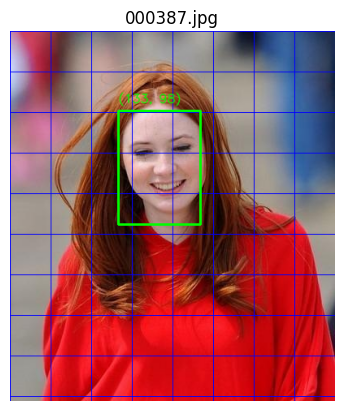

001993.jpg [(181, 111, 62, 86)]


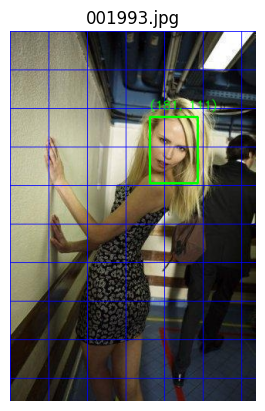

000113.jpg [(137, 22, 120, 166)]


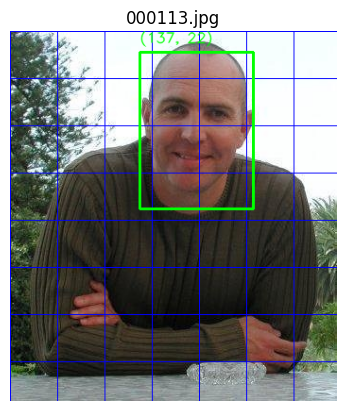


Avg size bounding box - Width: 196.68px, Height: 271.73px


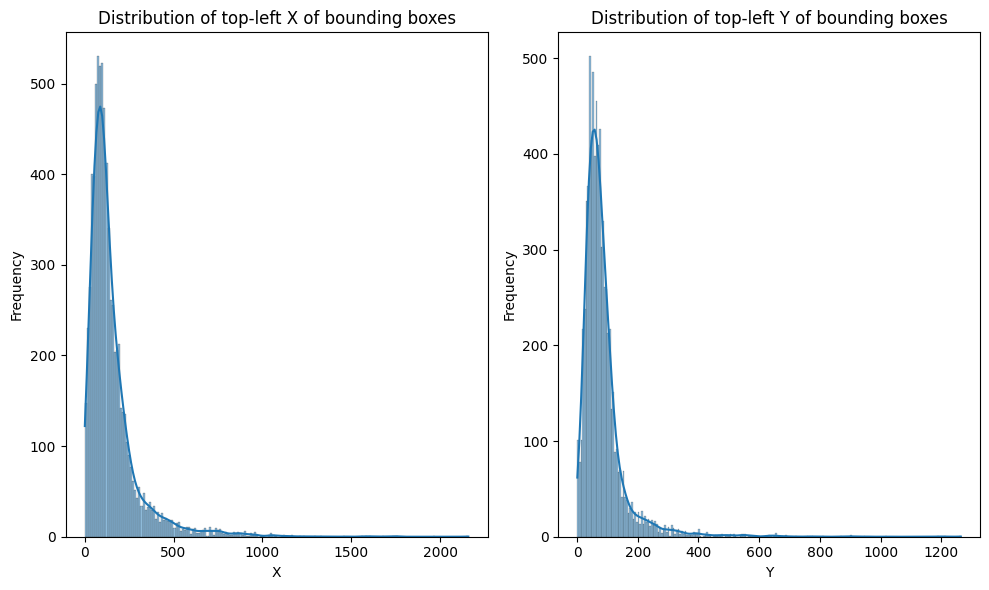

In [ ]:
train_annotations = load_face_annotations('/content/CelebA_train_images/CelebA_train/images', '/content/CelebA_train_annotations/celeba_face_split/celeba_face_train_bbx_gt.txt', False)
val_annotations = load_face_annotations('/content/CelebA_val_images/CelebA_val/images', '/content/CelebA_train_annotations/celeba_face_split/celeba_face_val_bbx_gt.txt', False)
test_annotations = load_face_annotations('/content/CelebA_test_images/CelebA_test/images', '/content/CelebA_train_annotations/celeba_face_split/celeba_face_test_filelist.txt', True)

show_face_annotations(train_annotations, '/content/CelebA_train_images/CelebA_train/images', 3)
calc_stas_face_annotations(train_annotations)

##2.3 Fase di preprocessing

In questa fase si effettuerà un ridimensionamento delle immagini (anche per alleggerire la computazione), si normalizzeranno i pixel e si adatteranno le annotazioni se necessario, al fine che tutti i dati siano in un formato standardizzato per l'addestramento vero e proprio. Si converte anche l'immagine in scala di grigi per alleggerire il training del modello.

Si stampa poi qualche immagine a campione col suo bounding box per verificare che non ci siano stati errori nel preprocessing.

Inoltre per essere certi che i box siano etichettati correttamente, si stampano anche le immagini coi relativi box etichettati a 1.

In [ ]:
def show_positive_windows(images, boxes, window_size=(64, 64), step_size=16, top_random=5):
    """
    Mostra le finestre etichettate come 1 (presenza di volto) sulle immagini.

    Args:
        images: Lista delle immagini.
        boxes: Lista annotazioni.
        window_size: Dimensione sliding window.
        step_size: Passo per le finestre lungo x e y.
        top_random: Numero di immagini da mostrare.

    Returns:
        -
    """
    for _ in range(top_random):
        idx = random.randint(0, len(images) - 1)
        img = images[idx]
        img_boxes = boxes[idx]

        h, w = img.shape[:2]
        fig, ax = plt.subplots(1)
        ax.imshow(img, cmap='gray' if img.ndim == 2 else None)

        count=0
        for y in range(0, h - window_size[1] , step_size):
            for x in range(0, w - window_size[0] , step_size):
                intersected = is_rect_intersected((x, y, window_size[0], window_size[1]), img_boxes[0])
                #print(f'Evaluating {x},{y} on image {h},{w} x {window_size[0]},{window_size[1]} against {img_boxes} : {intersected}')
                if intersected:
                    rect = plt.Rectangle((x, y), window_size[0], window_size[1], edgecolor='g', facecolor='none')
                    ax.add_patch(rect)
                    count=count+1
                    # if count == 2:
                    #   plt.title(f'Image index: {idx}')
                    #   plt.axis('off')
                    #   plt.show()
                    #   return


        plt.title(f'Image index: {idx}')
        plt.axis('off')
        plt.show()

Processed 1000 images from  /content/CelebA_train_images/CelebA_train/images (1000 images / 1000 boxes)
Processed 2000 images from  /content/CelebA_train_images/CelebA_train/images (2000 images / 2000 boxes)
Processed 3000 images from  /content/CelebA_train_images/CelebA_train/images (3000 images / 3000 boxes)
Processed 4000 images from  /content/CelebA_train_images/CelebA_train/images (4000 images / 4000 boxes)
Processed 5000 images from  /content/CelebA_train_images/CelebA_train/images (5000 images / 5000 boxes)
Processed 6000 images from  /content/CelebA_train_images/CelebA_train/images (6000 images / 6000 boxes)
Processed 7000 images from  /content/CelebA_train_images/CelebA_train/images (7000 images / 7000 boxes)
Processed 1000 images from  /content/CelebA_val_images/CelebA_val/images (1000 images / 1000 boxes)
Processed 1000 images from  /content/CelebA_test_images/CelebA_test/images (1000 images / 1000 boxes)


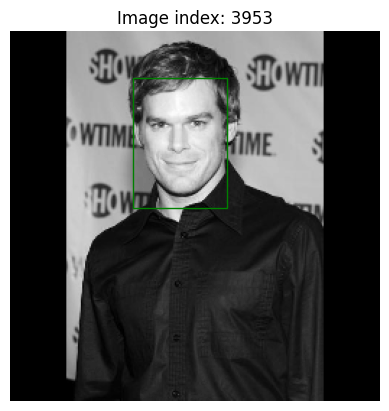

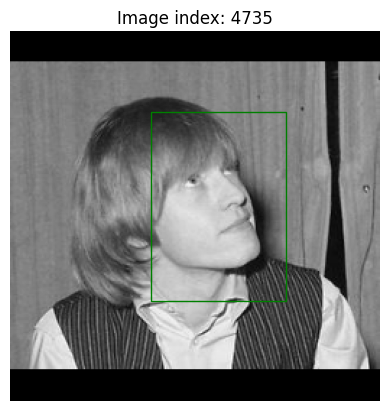

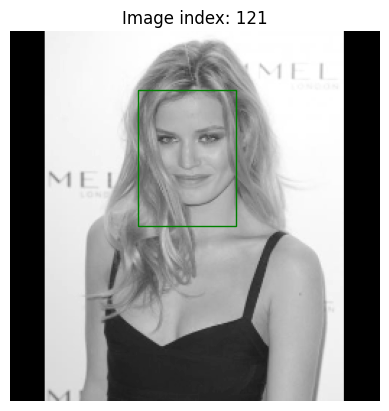

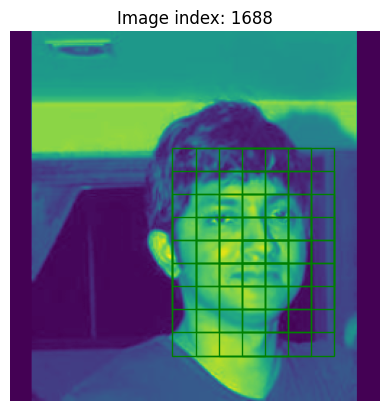

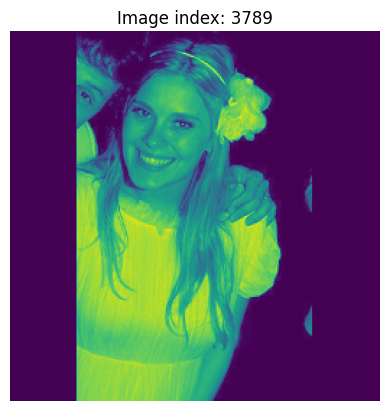

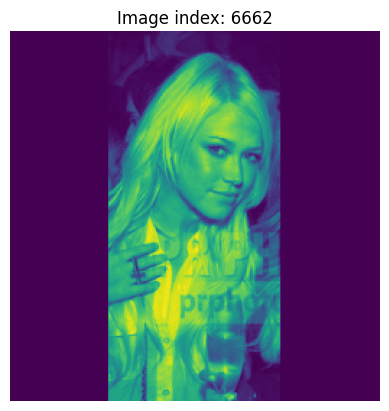

In [ ]:
train_images, train_boxes, _ = preprocess_dataset(train_annotations, '/content/CelebA_train_images/CelebA_train/images')
val_images, val_boxes, _ = preprocess_dataset(val_annotations, '/content/CelebA_val_images/CelebA_val/images')
test_images, _, test_images_transform = preprocess_dataset(test_annotations, '/content/CelebA_test_images/CelebA_test/images')

show_face_annotations_normalized(train_images, train_boxes, 3)
show_positive_windows(train_images, train_boxes, window_size=(64, 64), step_size=16, top_random=3)

##2.4 Fase di addestramento
Come tecnica di descrizione delle features si utilizza HOG (Histogram of Oriented Gradients) che oltre a non essere computazionalmente esoso, come da requisito, è poco sensibile al cambio di luminosità ed efficace nel riconoscimento dei contorni, per cui si presta alla nostra casistica.

Come classificatore binario (area con volto o no), si utilizza SVM lineare, per la sua bassa richiesta computazionale.

Di seguito si eseguono i seguenti step:
- si generano finestre all'interno delle immagini
- si usa HOG per estrarre le caratteristiche da ogni finestra
- si crea un etichetta binaria che indica se c'è o meno un volto
- si crea una pipeline che include lo step di standardizzazione dei dati
- si lancia l'addestramento del modello, si pone anche un limite alle features tramite PCA

> Fonti: [HOG](https://medium.com/mlcrunch/face-detection-using-dlib-hog-198414837945),  [HOG & Linear SVM](https://medium.com/@mithi/vehicles-tracking-with-hog-and-linear-svm-c9f27eaf521a)

In [ ]:
window_sizes = [(96, 96)]
step_size = 16
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

RANDOM_SEED=10

In [ ]:
train_hog_features, train_labels = extract_hog_features_from_windows(train_images, train_boxes)


<ipython-input-20-034f04a924ce>:35: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  feature = hog(window,orientations = 12, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, multichannel=False)


Images processed: 1000...
Images processed: 2000...
Images processed: 3000...
Images processed: 4000...
Images processed: 5000...
Images processed: 6000...
Images processed: 7000...
Images processed: 7491...
positive samples:  47418
negative samples:  219065
skipped samples:  639928
positive samples balanced: 47418
negative samples balanced: 47418


<ipython-input-21-6df8ec51bb21>:16: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  feature, hog_image = hog(image, orientations = 12, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True, multichannel=False)


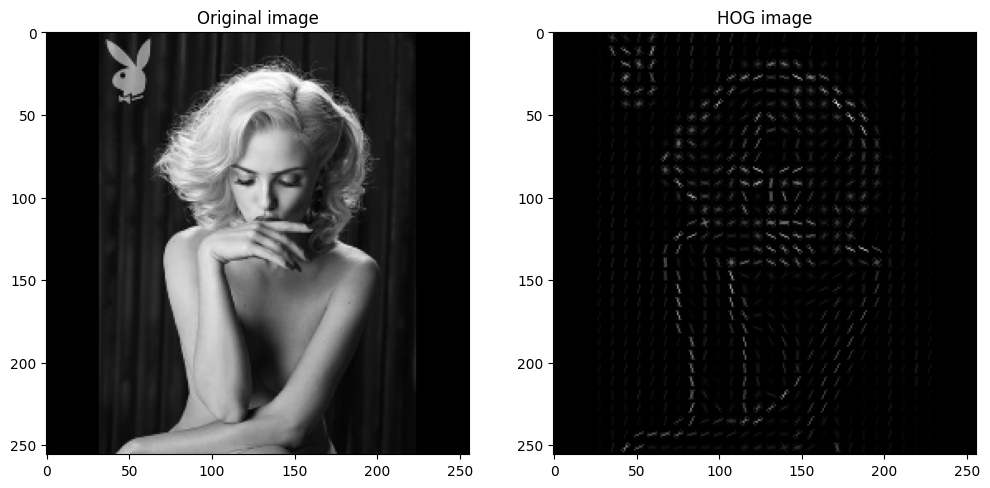

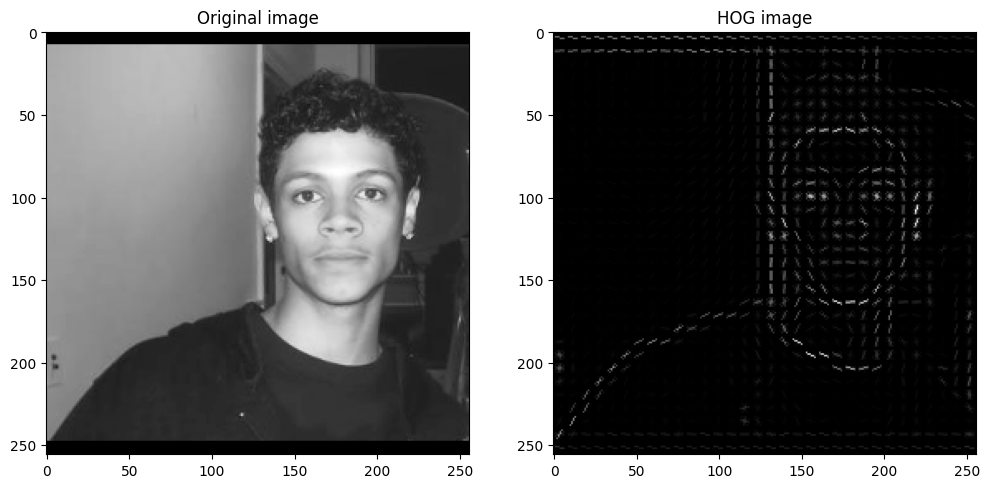

In [ ]:
num_samples_to_check = 2
for i in range(num_samples_to_check):
    image = train_images[i]
    feature, hog_image = visualize_hog(image)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG image')
    plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# pca = PCA(n_components=100)
# train_hog_features_pca = pca.fit_transform(train_hog_features)

# svm_model = make_pipeline(StandardScaler(),LinearSVC())

# param_grid = {
#     'linearsvc__C': [ 0.1, 1, 4, 8]
# }

# grid_search = GridSearchCV(svm_model, param_grid, refit=True, verbose=3)
# grid_search.fit(train_hog_features, train_labels)
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best Score: {grid_search.best_score_}")
# svm_model = grid_search.best_estimator_

best_params = {'C': 0.01 }
svm_model = make_pipeline(StandardScaler(), LinearSVC(**best_params))
svm_model.fit(train_hog_features, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=0.01))])

##2.5. Valutazione del modello

Una volta che abbiamo il modello, lo verifichiamo sul set dei dati di validation per capire come si comporta su dati nuovi. Verifichiamo anche i valori della confusion matrix per avere un'idea dei falsi positivi.

In [ ]:
val_hog_features, val_labels = extract_hog_features_from_windows(val_images, val_boxes)

val_pred = svm_model.predict(val_hog_features)

print(f'Accuracy: {accuracy_score(val_labels, val_pred):.2f}')
print(f'Precision: {precision_score(val_labels, val_pred):.2f}')
print(f'Recall: {recall_score(val_labels, val_pred):.2f}')
print(f'Confusion Matrix:\n {confusion_matrix(val_labels, val_pred)}')

<ipython-input-20-034f04a924ce>:35: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  feature = hog(window,orientations = 12, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, multichannel=False)


Images processed: 1000...
Images processed: 1605...
positive samples:  10480
negative samples:  46621
skipped samples:  137104
positive samples balanced: 10480
negative samples balanced: 10480
Accuracy: 0.90
Precision: 0.90
Recall: 0.92
Confusion Matrix:
 [[9360 1120]
 [ 888 9592]]


##2.6. Test del modello

Ora si prova a passare il modello il dataset di test per vedere il risultato finale. Per farlo, analogamente a quanto fatto durante il traning, su divise in finestre l'immagine e su ognuna si esegue il predict.

Si disegnano poi i bounding box associati alle immagini, riducendo le sovrapposizioni con il metodo NMS

> Fonti: [NMS](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c)

<ipython-input-27-fc7e93db605e>:27: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  feature = hog(window, orientations = 12, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, multichannel=False)


(121, 5808)


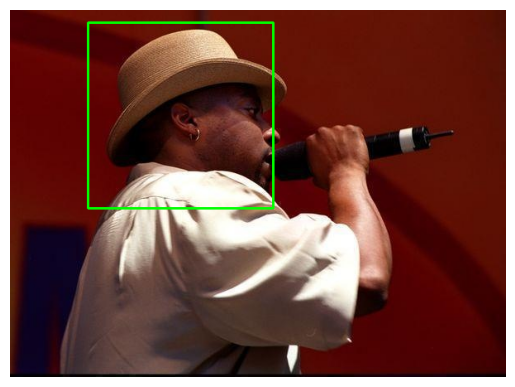

<ipython-input-27-fc7e93db605e>:27: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  feature = hog(window, orientations = 12, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, multichannel=False)


(121, 5808)


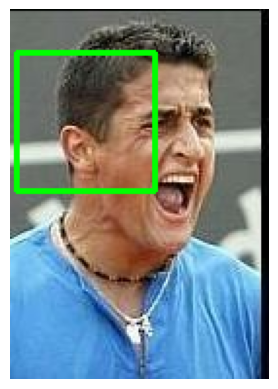

<ipython-input-27-fc7e93db605e>:27: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  feature = hog(window, orientations = 12, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, multichannel=False)


(121, 5808)


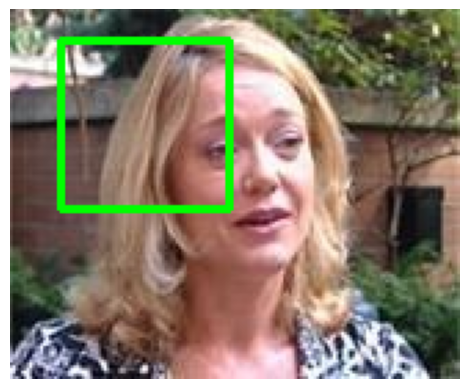

<ipython-input-27-fc7e93db605e>:27: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  feature = hog(window, orientations = 12, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, multichannel=False)


(121, 5808)


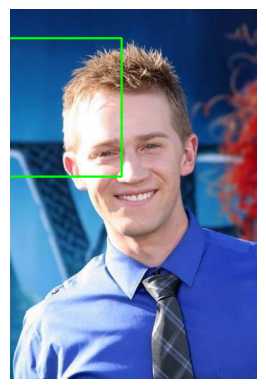

<ipython-input-27-fc7e93db605e>:27: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  feature = hog(window, orientations = 12, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, multichannel=False)


(121, 5808)


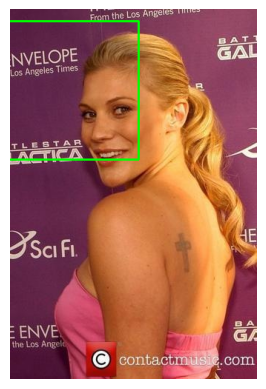

In [ ]:
random.seed(RANDOM_SEED)
top_random = 5

for _ in range(top_random):
  idx = random.randint(0, len(test_images) - 1)

  img = test_images[idx]
  img_transform = test_images_transform[idx]

  image_path = f'/content/CelebA_test_images/CelebA_test/images/{test_annotations[idx][0]}'
  img_original = cv2.imread(image_path)

  detected_boxes = detect_faces(img, svm_model)
  rescaled_boxes = rescale_boxes(detected_boxes, img_transform[0], img_transform[1], img_transform[2])

  draw_detected_faces(img_original, rescaled_boxes, True)

##2.7 Conclusioni
Con un dataset più semplice gli score sono migliori, attestandosi attorno al 90% come precision e accuracy. Anche in questo caso si sono fatti diversi tentativi calibrando diversamente i parametri di HOG e le size della windows, 96x96 sembra un buon compromesso per catturare la maggior parte dei volti del dataset.

Non si è riusciti a fare un test con SVM non lineari in quanto troppo onerosi dal punto di vista computazionale. Per lo stesso motivo non si è effettuato un addestramento con un dataset più corposo, che potrebbe portare a un ulteriore miglioramento.